In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import umap
import seaborn as sns
from sklearn import preprocessing
from Subgraph import subgraph
%load_ext autoreload
%autoreload 2

<a href=#1 knns>1. compute correlation between embeddings of genes and their k-NNs</a>   
<a href=#2 sub>2. analyze the common neighbors for some gene pairs</a> 

<a id="knns"></a>
1. embedding analysis  
(1) compute correlation between embeddings of genes and their k-NNs  
    - select 5 top k-NNs for a node
    - calculate 6 topological properties for each node and k-NNs  
    - calculate Pearson Correlations between a node's topological property and its k-NNs'  
(part of this code is adapted from https://github.com/GemsLab/StrucEmbedding-GraphLibrary )  

   (2) edge embeddings predict pair-based four topologial properties

In [2]:
import sys  
sys.path.append('..')
sys.path.append('../link_prediction')

In [3]:
import networkx as nx
from link_prediction.utils_link_prediction import *

In [4]:
def load_emb(dataset, chrom):

    data_root = '/data/kezhang/PBC_dataset/nature_data/new_dataset/'
    split_path = data_root + dataset + '/splitting'

    name = 'observed_{}_{}_40000'.format(chrom, chrom)

    X = np.load('{}/{}_80.0_x.npy'.format(split_path, name))
    y = np.load('{}/{}_80.0_y.npy'.format(split_path, name))

    emb_path = data_root + dataset + '/embeddings'
    emb_file0 = 'mlp_GNN_GAT/{}_80.0_es16_nl1_nhds1_clf_mlp'.format(name)
    emb_hicoex = np.load('{}/{}.npy'.format(emb_path, emb_file0))

    emb_file1 = 'topological/{}_80.0'.format(name)
    emb_topology = np.load('{}/{}.npy'.format(emb_path, emb_file1))

    adj_hic = np.load('{}{}/chromatin_networks/{}_80.0.npy'.format(data_root, dataset, name))
    graph_hic = from_numpy_matrix(adj_hic)
    graph_hic = nx.convert_node_labels_to_integers(graph_hic)
    
    emb_hicoex_node = emb_hicoex[np.unique(X)]
    emb_topology_node = emb_topology[np.unique(X)]
    
#     return graph_hic, emb_hicoex_node, emb_topology_node, X, y
    return graph_hic, emb_hicoex, emb_topology, X, y

In [5]:
from networkx.algorithms import approximation as approx

In [6]:
def compute_centrality(graph_hic, X):
    betweeness_centrality = emb_topology_node[:,1]
    clustering_coeff = emb_topology_node[:,2]
    
    degree_centrality = np.array(list(nx.degree_centrality(graph_hic).values()))
    
    pagerank = np.array(list(nx.pagerank(graph_hic).values()))
    
    shortest_path_lengths = np.array(list(
            map(lambda e: nx.shortest_path_length(graph_hic, e[0], e[1]) if nx.has_path(graph_hic, e[0],
                                                                                        e[1]) else np.nan,
                X)))
    jaccard_index = np.array(list(map(lambda e: e[2], nx.jaccard_coefficient(graph_hic, X))))
    
    resource_allocation_index = np.array(list(map(lambda e: e[2], nx.resource_allocation_index(graph_hic, X))))
#     all_pairs_node_connectivity = np.array(list(map(lambda e: nx.all_pairs_node_connectivity(graph_hic, e)[e[0]][e[1]], X[:2])))
    all_pairs_node_connectivity = np.array(list(map(lambda e: approx.local_node_connectivity(graph_hic, e[0], e[1]), X)))
    
    nan_idx = np.isnan(shortest_path_lengths)
    emb_topology_pair_shrt = shortest_path_lengths[~nan_idx]
    X_shrt = X[~nan_idx]
    shrt_node = []
    for i in np.unique(X_shrt):
        p = np.where(X_shrt==i)[0]
        shrt_node.append(np.sum(emb_topology_pair_shrt[p]))
        
    X_jacc = X
    jacc_node = []
    for i in np.unique(X_jacc):
        p = np.where(X_jacc==i)[0]
        jacc_node.append(np.sum(jaccard_index[p]))
       
    return (degree_centrality, betweeness_centrality, clustering_coeff, 
            pagerank, 
           shrt_node, jacc_node, X_shrt, X_jacc, jaccard_index, emb_topology_pair_shrt, 
            resource_allocation_index, all_pairs_node_connectivity)

In [7]:
def correlation(embedding, centrality, nodes, metric='euclidean', n_neighbors=5):
    from sklearn import metrics
    pairwise_distance = metrics.pairwise_distances(embedding, metric=metric)

    list_centrality = centrality    
    list_x, list_y = [], []
    for cur_node in range(0, len(nodes)):
        cur_sim_ranking = sorted(list(range(len(nodes))), key=lambda v: pairwise_distance[cur_node][v])[1:n_neighbors+1]
        list_y += [np.mean([list_centrality[i] for i in cur_sim_ranking])]
        list_x += [list_centrality[cur_node]]
    return np.corrcoef(list_x, list_y)[0,1]

(1) compute correlation between embeddings of genes and their k-NNs  
- select 5 top k-NNs for a node
- calculate 6 topological properties for each node and k-NNs  
- calculate Pearson Correlations between a node's topological property and its k-NNs'  

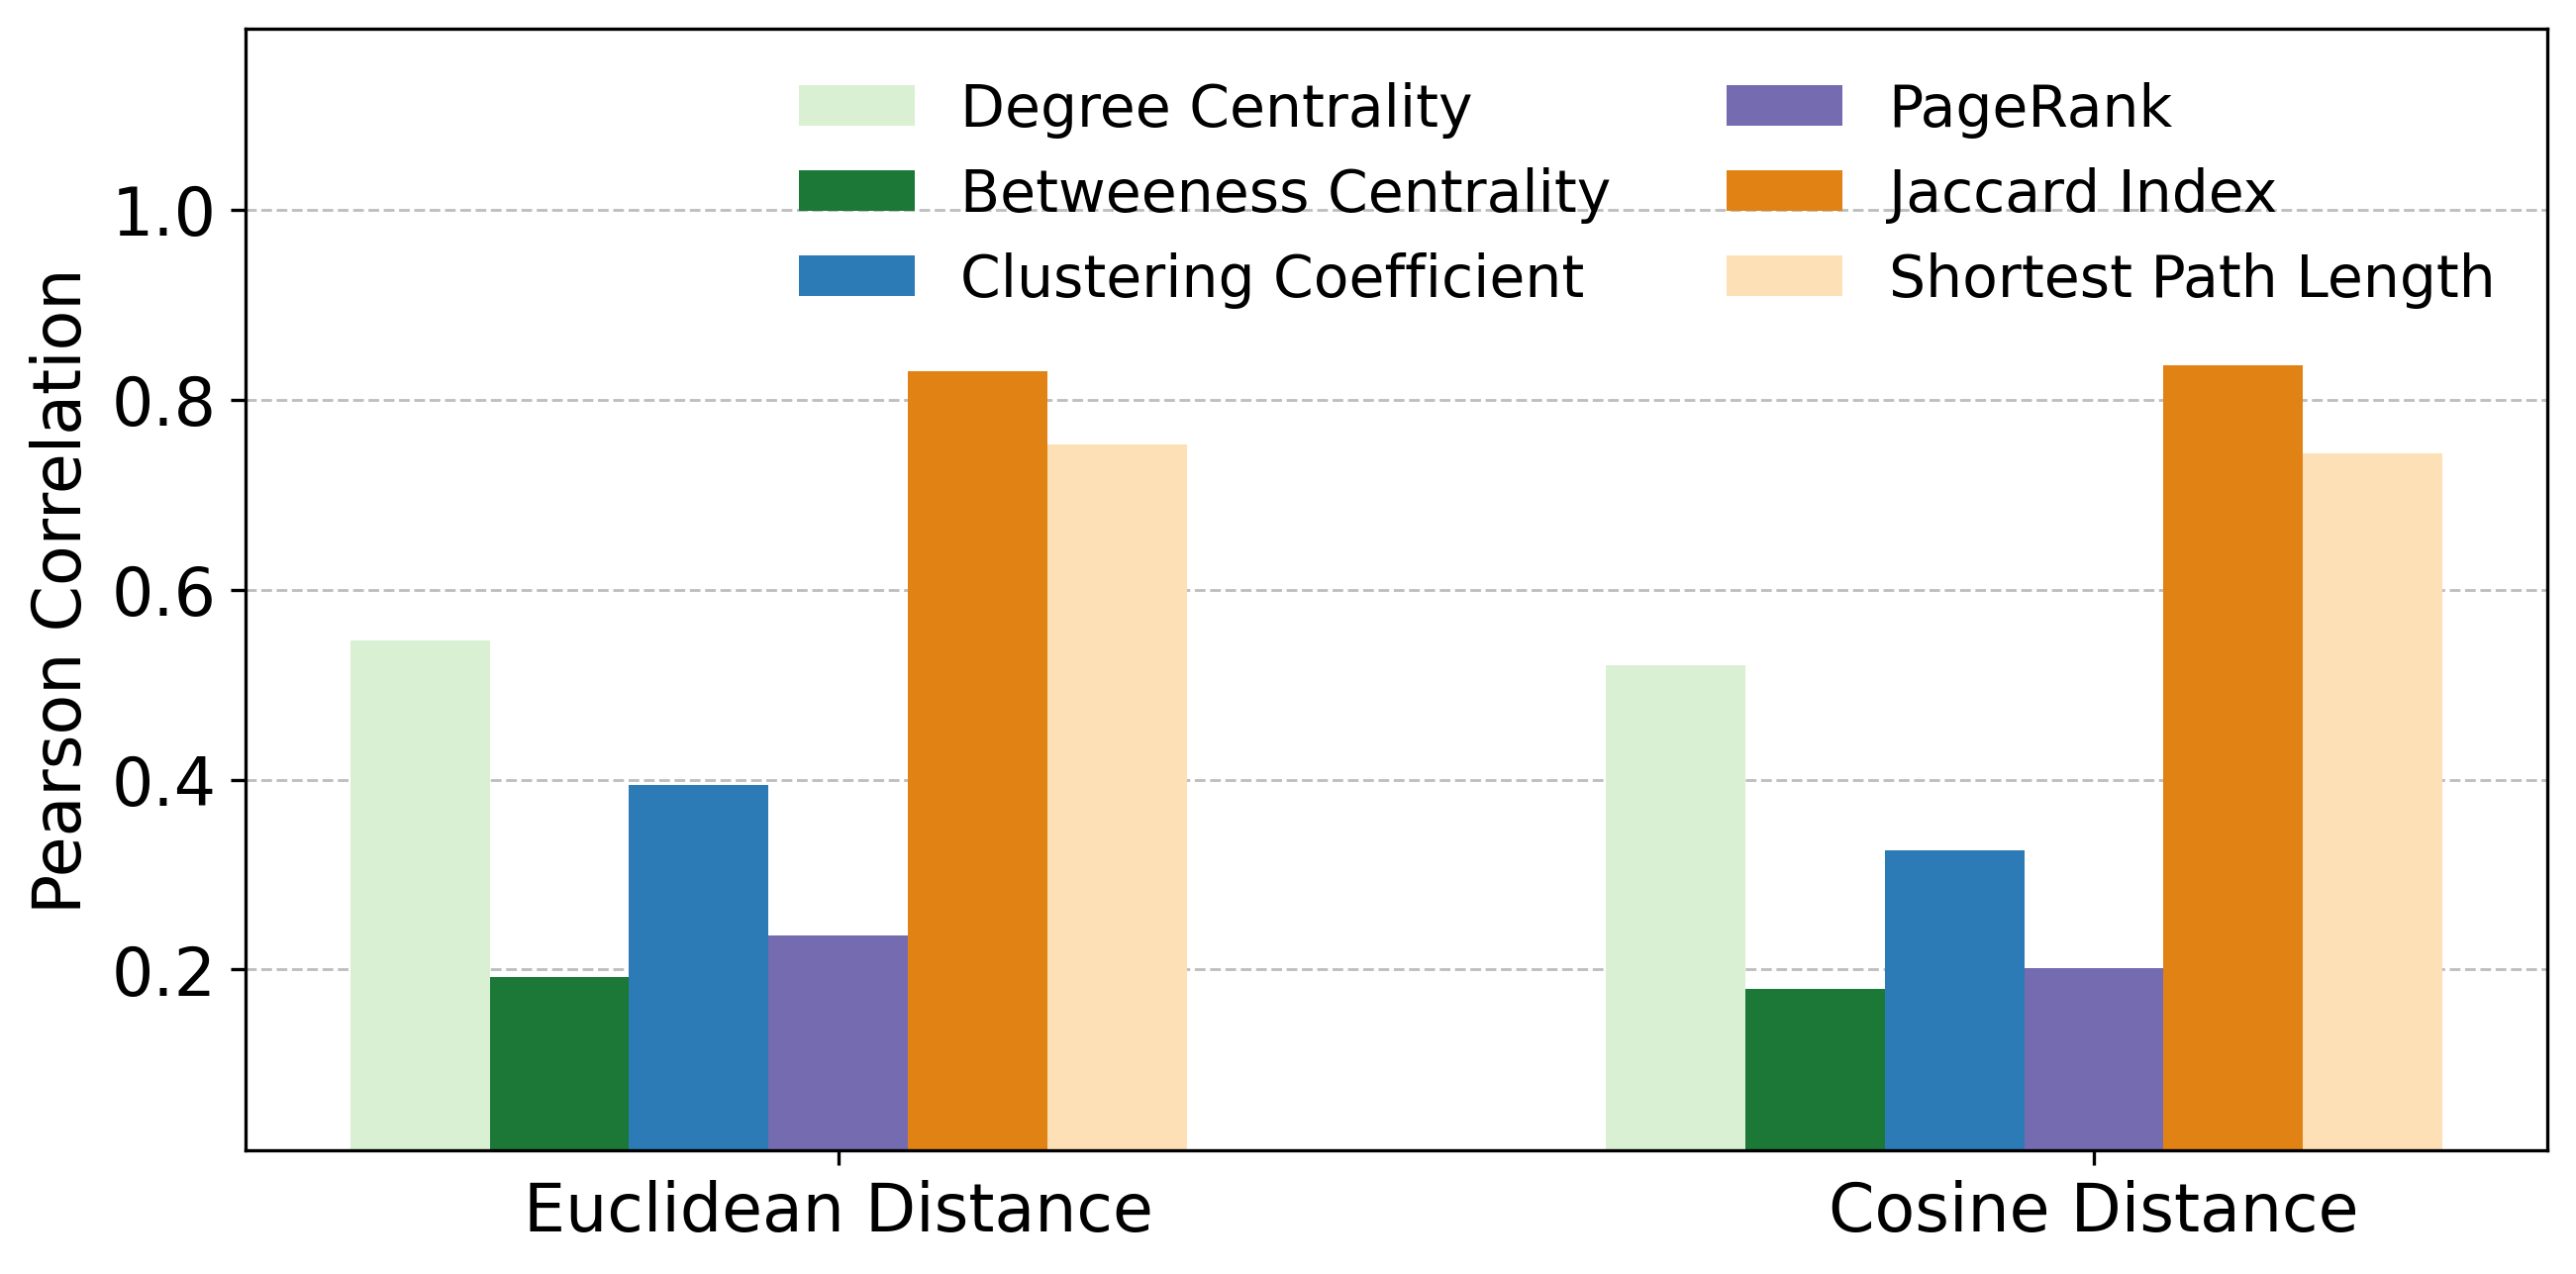

In [8]:
dataset = 'breast_cancer'
chrom = '7'
graph_hic, emb_hicoex, emb_topology, X, y = load_emb(dataset, chrom)
emb_topology_node = emb_topology[np.unique(X)]
centrality = compute_centrality(graph_hic, X)
degree_centrality, betweeness_centrality, clustering_coeff, pagerank_node, shrt_node, jacc_node, X_shrt, X_jacc, jaccard_index, _, _, _ = centrality
emb_hicoex_node = emb_hicoex[np.unique(X)]
corr_deg = {}
corr_deg['euclidean'] = correlation(emb_hicoex_node, degree_centrality, np.unique(X), 'euclidean')
corr_deg['cosine'] = correlation(emb_hicoex_node, degree_centrality, np.unique(X), 'cosine')

corr_betw = {}
corr_betw['euclidean'] = correlation(emb_hicoex_node, betweeness_centrality, np.unique(X), 'euclidean')
corr_betw['cosine'] = correlation(emb_hicoex_node, betweeness_centrality, np.unique(X), 'cosine')

corr_clust = {}
corr_clust['euclidean'] = correlation(emb_hicoex_node, clustering_coeff, np.unique(X), 'euclidean')
corr_clust['cosine'] = correlation(emb_hicoex_node, clustering_coeff, np.unique(X), 'cosine')

corr_page = {}
corr_page['euclidean'] = correlation(emb_hicoex_node, pagerank_node, np.unique(X), 'euclidean')
corr_page['cosine'] = correlation(emb_hicoex_node, pagerank_node, np.unique(X), 'cosine')

corr_jacc = {}
corr_jacc['euclidean'] = correlation(emb_hicoex_node, jacc_node, np.unique(X_jacc), 'euclidean')
corr_jacc['cosine'] = correlation(emb_hicoex_node, jacc_node, np.unique(X_jacc), 'cosine')

emb_hicoex_node = emb_hicoex[np.unique(X_shrt)]
corr_shrt = {}
corr_shrt['euclidean'] = correlation(emb_hicoex_node, shrt_node, np.unique(X_shrt), 'euclidean')
corr_shrt['cosine'] = correlation(emb_hicoex_node, shrt_node, np.unique(X_shrt),'cosine')

fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=300)
num = 2
total_width, n = 0.4, 6
width = total_width / n

pos_1 = [1+i*.6 for i in range(num)]
pos_2 = [p+width for p in pos_1]
pos_3 = [p+width for p in pos_2]
pos_4 = [p+width for p in pos_3]
pos_5 = [p+width for p in pos_4]
pos_6 = [p+width for p in pos_5]
ticks = (np.array(pos_1) + np.array(pos_2)) /2

ax.bar(pos_1, corr_deg.values(), width=width, label='Degree Centrality', color='#d9f0d3', alpha=1)   # # #e08214
ax.bar(pos_2, corr_betw.values(), width=width, label='Betweeness Centrality', color='#1b7837', alpha=1)
ax.bar(pos_3, corr_clust.values(), width=width, label='Clustering Coefficient', color='#2C7BB6', alpha=1)
ax.bar(pos_4, corr_page.values(), width=width, label='PageRank', color='#756bb1', alpha=1)
ax.bar(pos_5, corr_jacc.values(), width=width, label='Jaccard Index', color='#e08214', alpha=1)
ax.bar(pos_6, corr_shrt.values(), width=width, label='Shortest Path Length', color='#fee0b6', alpha=1)
ax.grid(zorder=1, axis='y', ls='--', lw=.7, alpha = .8)
ax.set_axisbelow(True)
yticklines = ax.yaxis.get_ticklines()[::1]
yticklines[0].set_visible(False)
yticks = ax.yaxis.get_ticklabels()[::1]
yticks[0].set_visible(False)
ygrd_lines = ax.get_ygridlines()
ygrd_lines[0].set_visible(False)    
fsz = 16
label = ['Euclidean Distance', 'Cosine Distance']
plt.ylim((0.01, 1.19))
plt.tick_params(labelsize = fsz)
plt.xticks(ticks=pos_4, labels=label,fontsize=fsz)
plt.ylabel('Pearson Correlation',fontdict={'fontfamily':'sans-serif', 'fontsize': fsz})
plt.legend(loc='upper right', ncol=2, framealpha=0,fontsize=14)

# plt.title('Correlation between embeddings and topological properties of chrom {} on {}'.format(chrom, dataset))
#     plt.savefig('New_Emb_correlation_{}_chr{}.jpg'.format(dataset, chrom),dpi=600)
# plt.savefig('Emb_correlation_{}_chr{}.eps'.format(dataset, chrom),dpi=600)
plt.show()

(2) edge embeddings predict pair-based four topologial properties 
- resource_allocation_index: related with the number of common neighbors  
- all_pairs_node_connectivity (pairwise node connectivity): 
between two distinct and nonadjacent nodes, the minimum number of nodes that must be removed to disconnect them, i.e., the number of node independent paths between two nodes.

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

In [13]:
dataset = 'breast_cancer'
# jacc_re, shrt_re, resall_re, all_pairs_conn_re = [], [], [], []
chrom_list = [5, 7, 16, 22]
for c in chrom_list:
    chrom = str(c)
    graph_hic, emb_hicoex, emb_topology, X, y = load_emb(dataset, chrom)
    emb_topology_node = emb_topology[np.unique(X)]
    emb_hicoex_node = emb_hicoex[np.unique(X)]

    centrality = compute_centrality(graph_hic, X)
    degree_centrality, betweeness_centrality, clustering_coeff, _, shrt_node, jacc_node, X_shrt, X_jacc, jacc_index, pair_shrt, resource_allocation_index, all_pairs_node_connectivity = centrality

    X_ = emb_hicoex[X_jacc[:,0]] * emb_hicoex[X_jacc[:,1]]
    y_ = jacc_index
    neigh = KNeighborsRegressor(n_neighbors=5)
    jacc_tmp = cross_validate(neigh, X_, y_, cv=5, scoring='neg_root_mean_squared_error')
    jacc_rmse = -jacc_tmp['test_score'].mean()
    
    X_ = emb_hicoex[X_shrt[:,0]] * emb_hicoex[X_shrt[:,1]]
    y_ = pair_shrt
    neigh = KNeighborsRegressor(n_neighbors=5)
    shrt_tmp = cross_validate(neigh, X_, y_, cv=5, scoring='neg_root_mean_squared_error')
    shrt_rmse = -shrt_tmp['test_score'].mean()
    
    X_ = emb_hicoex[X[:,0]] * emb_hicoex[X[:,1]]
    y_ = resource_allocation_index
    neigh = KNeighborsRegressor(n_neighbors=5)
    resall_tmp = cross_validate(neigh, X_, y_, cv=5, scoring='neg_root_mean_squared_error')
    resall_rmse = -resall_tmp['test_score'].mean()
    
    X_ = emb_hicoex[X[:,0]] * emb_hicoex[X[:,1]]
    y_ = all_pairs_node_connectivity
    neigh = KNeighborsRegressor(n_neighbors=5)
    all_pairs_conn_tmp = cross_validate(neigh, X_, y_, cv=5, scoring='neg_root_mean_squared_error')
    all_pairs_conn_rmse = -all_pairs_conn_tmp['test_score'].mean()
    
    print(jacc_tmp)
    print(shrt_tmp)
    print(resall_tmp)
    jacc_re.append(jacc_rmse)
    shrt_re.append(shrt_rmse)
    resall_re.append(resall_rmse)
    all_pairs_conn_re.append(all_pairs_conn_rmse)

{'fit_time': array([0.00191879, 0.00249839, 0.00239849, 0.00187039, 0.00180364]), 'score_time': array([6.2080617 , 6.92263794, 6.71171546, 5.60793805, 5.24224234]), 'test_score': array([-0.05953292, -0.06510391, -0.05375917, -0.05903947, -0.06081245])}
{'fit_time': array([0.00099754, 0.00087357, 0.00095677, 0.00098467, 0.00094962]), 'score_time': array([0.6042943 , 0.68945289, 0.65360093, 0.65982533, 0.64099622]), 'test_score': array([-3.52881239, -3.49704637, -3.50119342, -3.53186701, -3.50232024])}
{'fit_time': array([0.00167561, 0.00164366, 0.00163007, 0.00176334, 0.00173044]), 'score_time': array([5.18278694, 5.42234421, 5.30290842, 5.42638946, 5.5736742 ]), 'test_score': array([-0.07316102, -0.08494947, -0.07946277, -0.07954085, -0.07894203])}
{'fit_time': array([0.00183868, 0.00145006, 0.00145698, 0.00151587, 0.0014751 ]), 'score_time': array([3.95175648, 3.58168721, 3.88405704, 3.80832338, 3.76099253]), 'test_score': array([-0.06106259, -0.06301708, -0.06737535, -0.06236697, -0.

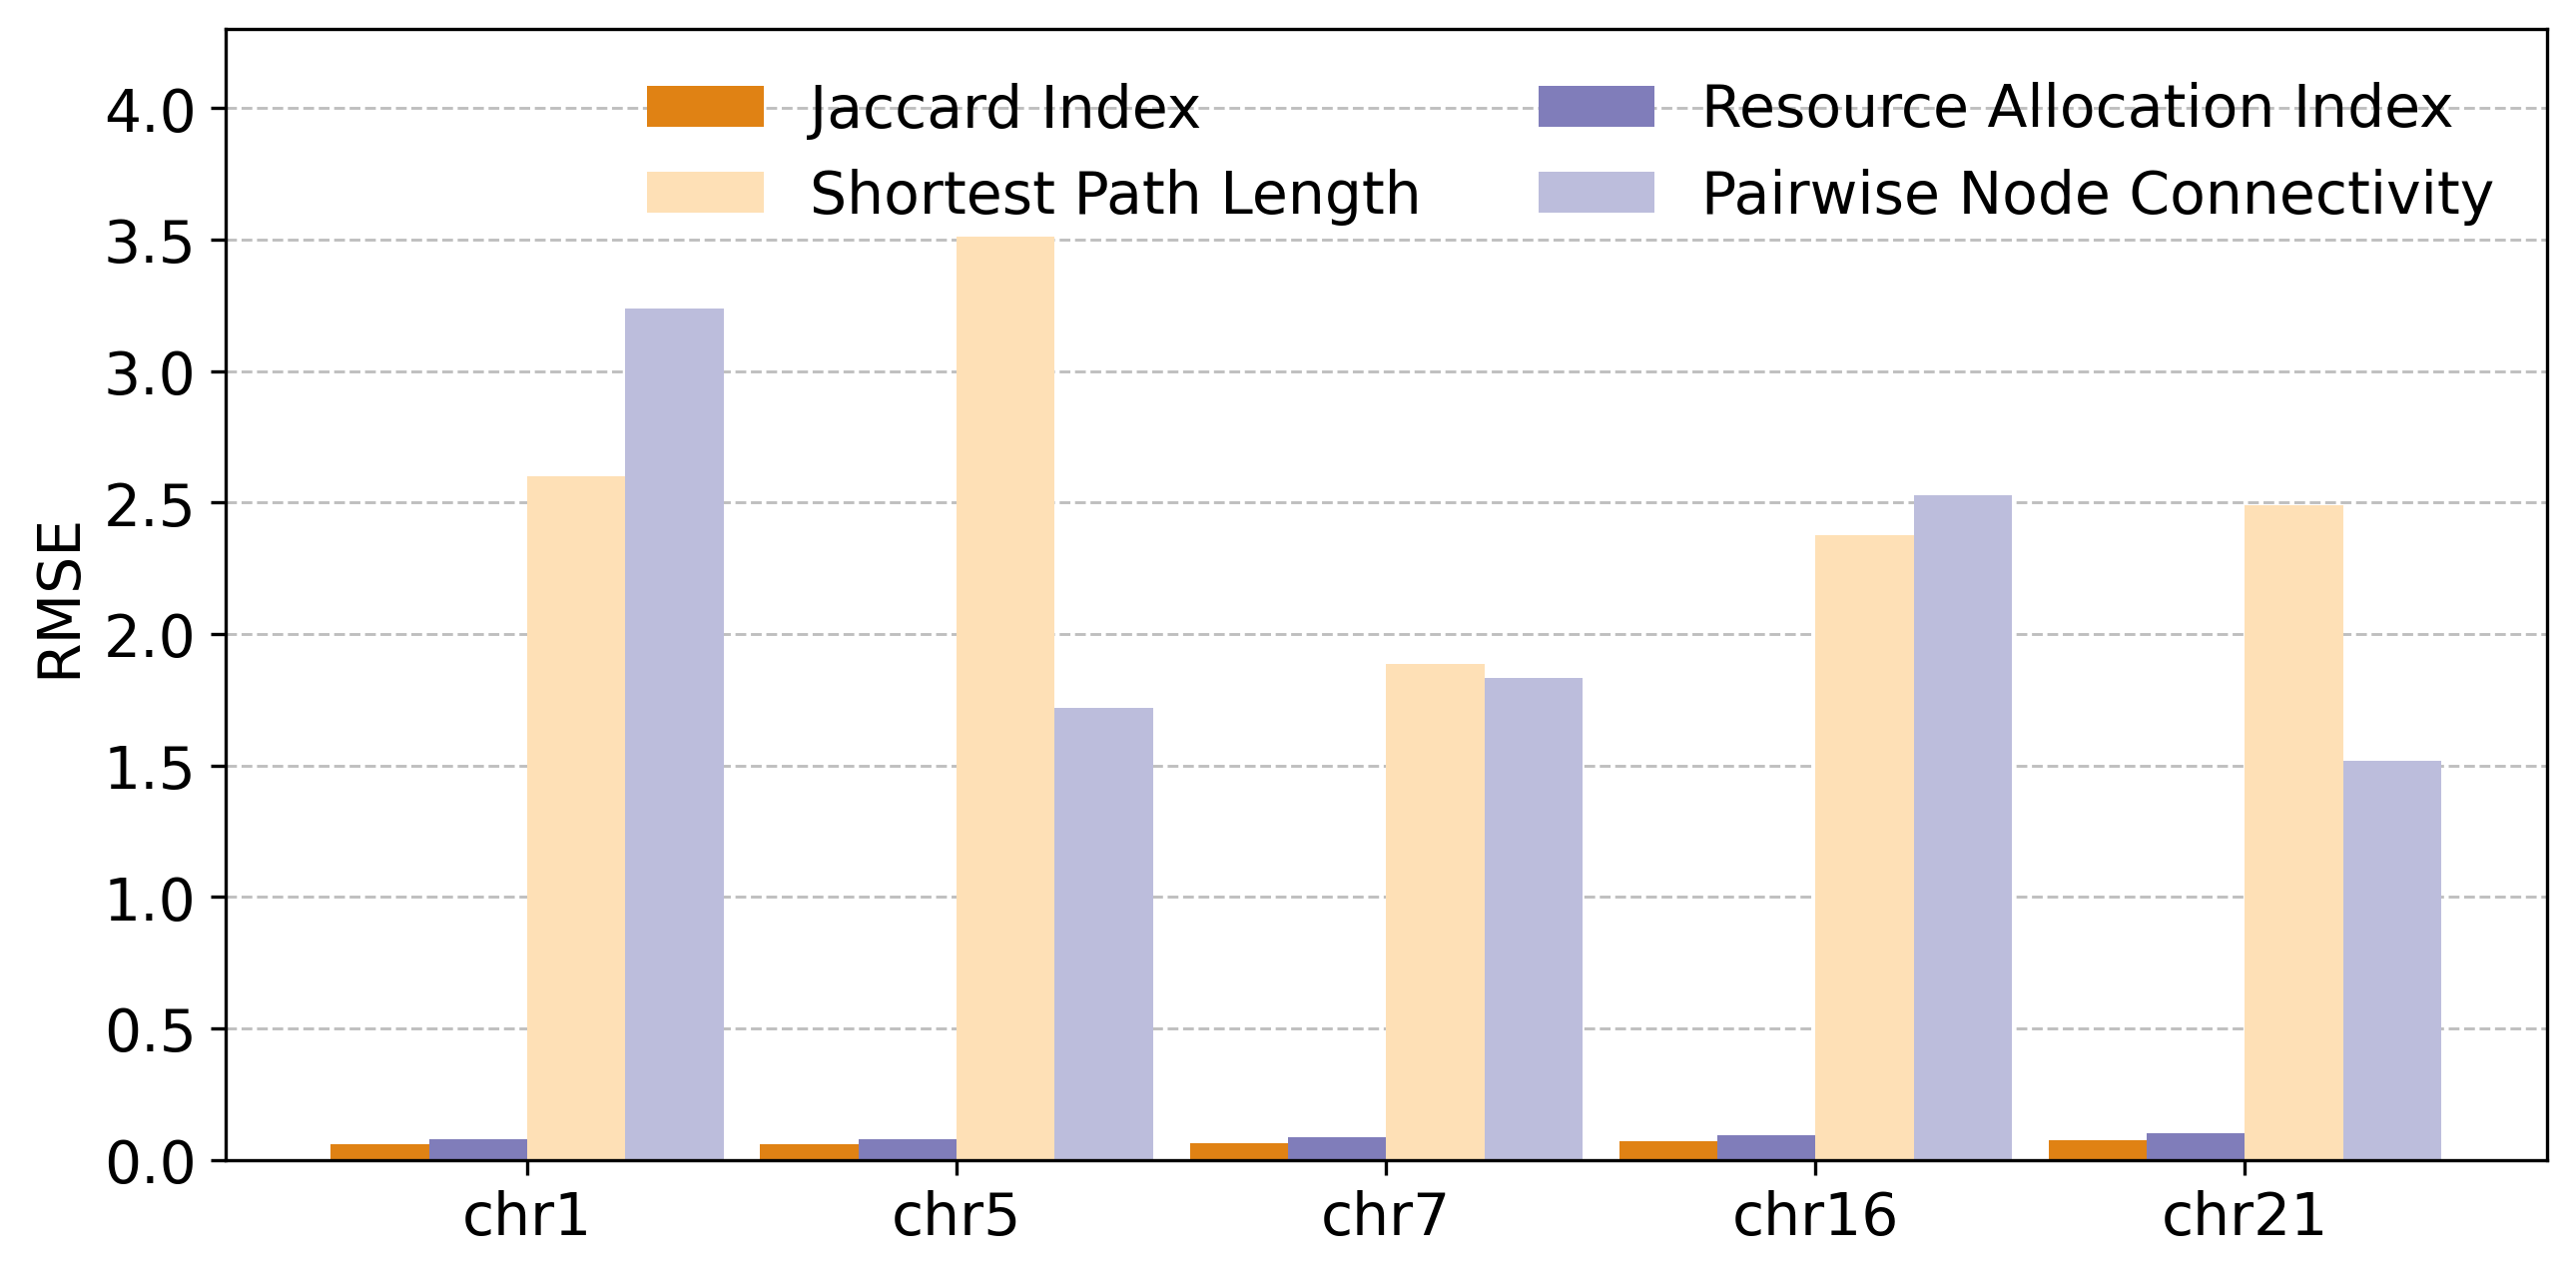

In [14]:
plot_jacc = jacc_re
plot_shrt = shrt_re
plot_resall = resall_re
plot_all_pairs_conn = all_pairs_conn_re


fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=300)
num = len(plot_jacc)
total_width, n = 0.8, 5
width = total_width / n

pos_1 = [1+i*.7 for i in range(num)]
pos_2 = [p+width for p in pos_1]
pos_3 = [p+width for p in pos_2]
pos_4 = [p+width for p in pos_3]
ticks = (np.array(pos_2) + np.array(pos_3)) /2
# ticks = pos_2
    
ax.bar(pos_1, plot_jacc[:num], width=width, label='Jaccard Index', color='#e08214', alpha=1)   # # #e08214
ax.bar(pos_3, plot_shrt[:num], width=width, label='Shortest Path Length', color='#fee0b6', alpha=1)
ax.bar(pos_2, plot_resall[:num], width=width, label='Resource Allocation Index', color='#807dba', alpha=1)
ax.bar(pos_4, plot_all_pairs_conn[:num], width=width, label='Pairwise Node Connectivity', color='#bcbddc', alpha=1)

ax.grid(zorder=1, axis='y', ls='--', lw=.7, alpha = .8)
ax.set_axisbelow(True)
fsz = 14
label = ['chr1', 'chr5', 'chr7', 'chr16', 'chr21']
plt.ylim((0, 4.3))
plt.tick_params(labelsize = fsz)
plt.xticks(ticks=ticks, labels=label,fontsize=fsz)
plt.ylabel('RMSE',fontdict={'fontfamily':'sans-serif', 'fontsize': fsz})
plt.legend(loc='upper right', ncol=2, framealpha=0,fontsize=fsz)

# plt.savefig('Edge_Emb_pred_topology_{}.jpg'.format(dataset),dpi=600)
plt.show()

<a id="sub"></a>
2. analyze the common neighbors for some gene pairs
- select gene pairs, here we only consider gene pairs which are both contacted and co-expressed with each other
- get the intersection subgraph for each gene pair
- find common neighbors for each gene pair 
- filtered out gene pairs with few common neighbors, and then picked the chromosomes with sufficient gene pairs
- query enhancers from Enhancer atlas v2.0 (http://www.enhanceratlas.org/)
- count the gene neighbors, which co-expressed with at least one central genes and contact both central genes, share enhancers with both of them.
 
 
(1) compare COPs vs. non-COPs  
(2) compare common neighbors vs. all neighbors (for COPs)

In [15]:
def get_data(chrom, dataset):
    data_root = '/data/kezhang/PBC_dataset/nature_data/new_dataset/'
    name_coexp = 'coexpression_chr_{}_{}'.format(chrom, chrom)
    name_hic = 'observed_{}_{}_40000'.format(chrom, chrom)

    dataset = 'breast_cancer'
    mcf7_coexp = np.load('{}{}/coexpression_networks/{}_90.0.npy'.format(data_root, dataset, name_coexp))
    mcf7_hic = np.load('{}{}/chromatin_networks/{}_80.0.npy'.format(data_root, dataset, name_hic))
    degrees = np.nansum(mcf7_hic, axis=0)
    disconnected_nodes_mcf7 = np.ravel(np.argwhere(degrees == 0))
    mcf7_pairs = np.stack(np.where((mcf7_coexp == 1))).T

    mcf7_rna = pd.read_csv('{}/{}/rna/expression_info_chr_{}.csv'.format(data_root, dataset,chrom))

    mcf7_dico_pair, mcf7_dico_pairname = [], []
    for u,v in mcf7_pairs:
        if (u not in disconnected_nodes_mcf7) and (v not in disconnected_nodes_mcf7):
            mcf7_dico_pair.append([(u,v),(mcf7_rna.loc[u,'Gene name'], mcf7_rna.loc[v,'Gene name'])])

    mcf7_dif = pd.DataFrame(data=mcf7_dico_pair, columns=['u,v','name'])
    mcf7_dif.loc[:,'u_name'] = np.stack(mcf7_dif['name'])[:,0]
    mcf7_dif.loc[:,'v_name'] = np.stack(mcf7_dif['name'])[:,1]
    
    pair_list = mcf7_dif['u,v'].values
    r, c = np.stack(pair_list).T
    pair_list_11 = pair_list[(mcf7_hic[r,c] == 1) & (mcf7_coexp[r,c] == 1)]
    
    return pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif

In [16]:
def get_diffdata(chrom, mcf7_hic, mcf7_coep, mcf7_dif):
    pair_list = mcf7_dif['u,v'].values
    r, c = np.stack(pair_list).T
    pair_list_11 = pair_list[(mcf7_hic[r,c] == 1) & (mcf7_coexp[r,c] == 1)]
    return pair_list_11

In [17]:
def get_localdict(hic, pair_list):
    
    hic = np.triu(hic, 1)
    hic = hic + hic.T
    hic = np.nan_to_num(hic)
    graph = np.stack(np.where(hic > 0))
    
    pair_list = np.stack(pair_list_11)
    local_dict = {}
    for i in range(0, len(pair_list)):
        pair = pair_list[i,:]
        local_graph = subgraph(graph, pair)
#         ipdb.set_trace()
        idx = np.where((local_graph[0,:]==pair[0])|(local_graph[0,:]==pair[1]))[0]
        local_graph = local_graph[:,idx]
                
        local_dict[tuple(pair)] = local_graph.T
    return local_dict

In [43]:
def get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10):
    shared_nodes = []
    for i in range(len(pair_list_11)):
        u,v = pair_list_11[i]
        neighbor_pairs = local_dict[(u,v)]
        n1 = neighbor_pairs[np.where(neighbor_pairs == pair_list_11[i][0])[0]]
        n2 = neighbor_pairs[np.where(neighbor_pairs == pair_list_11[i][1])[0]]
        if union:
            s = np.union1d(n1, n2)
        else:
            s = np.intersect1d(n1, n2)
        shared_nodes.append(s.tolist())

    signifi_shared = [[i,s] for i,s in enumerate(shared_nodes) if len(s)-2 >= num_nei]
    signifi_genes = [mcf7_rna.loc[s, 'Gene name'].values for s in shared_nodes if len(s)-2 >= num_nei]
    return signifi_shared,signifi_genes

In [19]:
E_P = pd.read_csv('enhancer_atlas_MCF-7_EP.txt',sep='\t',header=None)
E_P['enhancer'] = E_P[0].apply(lambda x: x.split('_')[0])
E_P['gene'] = E_P[0].apply(lambda x: x.split('$')[-4])
E_P['chrom'] = E_P[0].apply(lambda x: x.split('$')[-3])
E_P['TSS'] = E_P[0].apply(lambda x: x.split('$')[-2])
E_P['strand'] = E_P[0].apply(lambda x: x.split('$')[-1])
E_P.rename(columns={1: 'predicted score'}, inplace=True)
E_P.drop(columns=[0], inplace=True)
E_P.head()

,predicted score,enhancer,gene,chrom,TSS,strand
0,0.602533,chr1:955750-957580,AL669831.1,chr1,721320,+
1,1.087982,chr1:1132570-1132810,AL669831.1,chr1,721320,+
2,1.283281,chr1:1014690-1017190,AL669831.1,chr1,721320,+
3,2.397889,chr1:955750-957580,NOC2L,chr1,894689,-
4,1.680626,chr1:976260-976550,NOC2L,chr1,894689,-


In [20]:
def shareE_analysis_atlas(chrom, enhancers, signifi_shared, signifi_genes, pair_list_11, local_dict, mcf7_rna, mcf7_coexp, skip=False):
    mcf7_E_all = enhancers[enhancers['chrom'] == 'chr'+chrom]
    
    mcf7_coexp_ = np.nan_to_num(mcf7_coexp)
    mcf7_coexp1 = mcf7_coexp_ + mcf7_coexp_.T
    
    shared_dict_all = {}  # all common neighbors, attention, and co-exp labels 
    share_dict = {}       # common neighbors in shared_dict_all
    share_dict_E = {}     # enhancers shared by neighbors and genes
    share_dict_gene = {}  # the set of all gene-neighbors that share same enhancer in share_dict_E with a gene or both two genes
    share_dict_itset = {}  # neighbor set that shared enhancers with both of two genes
    x1 = []
    y1 = []
    for i in range(len(signifi_shared)):
        (u,v) = pair_list_11[signifi_shared[i][0]]
        mask = np.isin(local_dict[(u,v)], signifi_shared[i][1])
        shared_dict = local_dict[(u,v)][mask[:,1]]

        u_name = mcf7_rna.loc[u, 'Gene name']
        v_name = mcf7_rna.loc[v, 'Gene name']
        
        # skip the gene pairs which already contact with same enhancers
        if skip:
            mcf7_E_uv = mcf7_E_all[mcf7_E_all['gene'].isin([u_name, v_name])]
            mcf7_E_uv.loc[:,'enhancer'] = mcf7_E_uv['enhancer'].astype(str)
            if len(mcf7_E_uv) < 2 or (mcf7_E_uv['enhancer'].isna()).sum() > 0:
                continue

            E_uv = [e.split(';') for e in mcf7_E_uv['enhancer']]
            E_count_uv = pd.value_counts(np.hstack(E_uv))
            if (E_count_uv==2).sum() > 0:
                continue
            
        shared_dict_all[(u_name, v_name)] = shared_dict
        
        share_set = signifi_genes[i].tolist()
        
        mcf7_E0 = mcf7_E_all[mcf7_E_all['gene'].isin(share_set)]
        mcf7_E1 = mcf7_E0.loc[~mcf7_E0['enhancer'].isna()]
        mcf7_E1.loc[:,'enhancer'] = mcf7_E1['enhancer'].astype(str)
        
        E = [e.split(';') for e in mcf7_E1['enhancer']]
        if len(E) == 0:
            continue
        E_count = pd.value_counts(np.hstack(E))
        share_E = E_count[E_count>=2]      

        share_E1_u, share_E1_v = [],[]
        share_E1_geneu,share_E1_genev = [],[]
        for e in share_E.index.values:
            E_gene = mcf7_E1.loc[mcf7_E1['enhancer'].str.contains(e),'gene']
            if u_name in E_gene.tolist():
                share_E1_u.append(e)
                share_E1_geneu.append(E_gene.tolist())
            if v_name in E_gene.tolist():
                share_E1_v.append(e)
                share_E1_genev.append(E_gene.tolist())
        
        if len(share_E1_geneu) > 0 and len(share_E1_genev) > 0:
            share_E1_setu = np.unique(np.hstack(share_E1_geneu))
            share_E1_setv = np.unique(np.hstack(share_E1_genev))
            share_E1_setu = share_E1_setu[share_E1_setu != u_name]
            share_E1_setv = share_E1_setv[share_E1_setv != v_name]
            share_E1_uv = np.intersect1d(share_E1_setu, share_E1_setv)
            
            if len(share_E1_uv) > 0:
# #                 if only count the gene-neighbor pairs in which neighbors share E with both genes
#                 share_E1_u_ = [t for s,t in zip(share_E1_geneu,share_E1_u) if len(list(set(s).intersection(set(share_E1_uv))))>0]
#                 share_E1_v_ = [t for s,t in zip(share_E1_genev,share_E1_v) if len(list(set(s).intersection(set(share_E1_uv))))>0]         
#                 share_E1_geneu_ = [s for s in share_E1_geneu if len(list(set(s).intersection(set(share_E1_uv))))>0]
#                 share_E1_genev_ = [s for s in share_E1_genev if len(list(set(s).intersection(set(share_E1_uv))))>0]

                tmp = share_E1_u + share_E1_v
                tmp1 = share_E1_geneu + share_E1_genev
 
                share_set.remove(u_name)
                share_set.remove(v_name)    
                share_dict[(u_name,v_name)] = share_set
                share_dict_E[(u_name,v_name)] = tmp
                share_dict_gene[(u_name,v_name)] = tmp1
                share_dict_itset[(u_name,v_name)] = share_E1_uv

                # -------------statistical analysis--------------               
                j1 = mcf7_rna[mcf7_rna['Gene name'].isin(share_E1_uv)].index.values.tolist()
                r,c = shared_dict.T
                j2_ = c
                uv_coexp = mcf7_coexp1[r,c]
                uv_11_id = np.where(uv_coexp==1)[0]
                
                share_coexp = len(np.unique(j2_[uv_11_id]))
                share_E_coexp = len(np.intersect1d(np.unique(j2_[uv_11_id]), j1))
            
                if share_coexp > 0:
                    all_nei = np.unique(local_dict[(u,v)][:,1])
                    x1.append(share_E_coexp/len(all_nei))
                else:
                    x1.append(0)


    share_all = (shared_dict_all, share_dict, share_dict_E, share_dict_gene, share_dict_itset)
    return share_all, x1, y1

In [39]:
from ShareE_analysis import shareE_analysis_atlas

(1) compare COPs vs. non-COPs

In [40]:
def get_data_10(chrom, dataset):
    data_root = '/data/kezhang/PBC_dataset/nature_data/new_dataset/'
    name_coexp = 'coexpression_chr_{}_{}'.format(chrom, chrom)
    name_hic = 'observed_{}_{}_40000'.format(chrom, chrom)

    dataset = 'breast_cancer'
    mcf7_coexp = np.load('{}{}/coexpression_networks/{}_90.0.npy'.format(data_root, dataset, name_coexp))
    mcf7_hic = np.load('{}{}/chromatin_networks/{}_80.0.npy'.format(data_root, dataset, name_hic))
    degrees = np.nansum(mcf7_hic, axis=0)
    disconnected_nodes_mcf7 = np.ravel(np.argwhere(degrees == 0))
    mcf7_pairs = np.stack(np.where((mcf7_coexp == 0))).T

    mcf7_rna = pd.read_csv('{}/{}/rna/expression_info_chr_{}.csv'.format(data_root, dataset,chrom))

    mcf7_dico_pair, mcf7_dico_pairname = [], []
    for u,v in mcf7_pairs:
        if (u not in disconnected_nodes_mcf7) and (v not in disconnected_nodes_mcf7):
            mcf7_dico_pair.append([(u,v),(mcf7_rna.loc[u,'Gene name'], mcf7_rna.loc[v,'Gene name'])])

    mcf7_dif = pd.DataFrame(data=mcf7_dico_pair, columns=['u,v','name'])
    mcf7_dif.loc[:,'u_name'] = np.stack(mcf7_dif['name'])[:,0]
    mcf7_dif.loc[:,'v_name'] = np.stack(mcf7_dif['name'])[:,1]
    
    pair_list = mcf7_dif['u,v'].values
    r, c = np.stack(pair_list).T
    pair_list_0 = pair_list[(mcf7_hic[r,c] == 1) & (mcf7_coexp[r,c] == 0)]
    
    return pair_list_0, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif

In [44]:
#(1,1)
chrom = '1'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all_1, x1_1 = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
#(1,0)
chrom = '1'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data_10(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all_1_, x1_1_ = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)

In [45]:
#(1,1)
chrom = '9'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all_9, x1_9 = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
#(1,0)
chrom = '9'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data_10(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all_9_, x1_9_ = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)

In [46]:
#(1,1)
chrom = '11'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all_11, x1_11 = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
#(1,0)
chrom = '11'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data_10(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all_11_, x1_11_ = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)

In [47]:
#(1,1)
chrom = '16'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna_11, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna_11, union=False, num_nei=10)
share_all_16, x1_16 = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna_11, mcf7_coexp, random=False, skip=False)
#(1,1)
chrom = '16'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna_10, mcf7_hic, mcf7_coexp, mcf7_dif = get_data_10(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna_10, union=False, num_nei=10)
share_all_16_, x1_16_ = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna_10, mcf7_coexp, random=False, skip=False)

In [48]:
#(1,1)
chrom = '17'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all_17, x1_17 = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
#(1,1)
chrom = '17'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data_10(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all_17_, x1_17_ = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)

In [49]:
x1_all_supp = [x1_1, x1_9, x1_11, x1_16, x1_17]
x1_all_supp_ = [x1_1_, x1_9_, x1_11_, x1_16_, x1_17_]

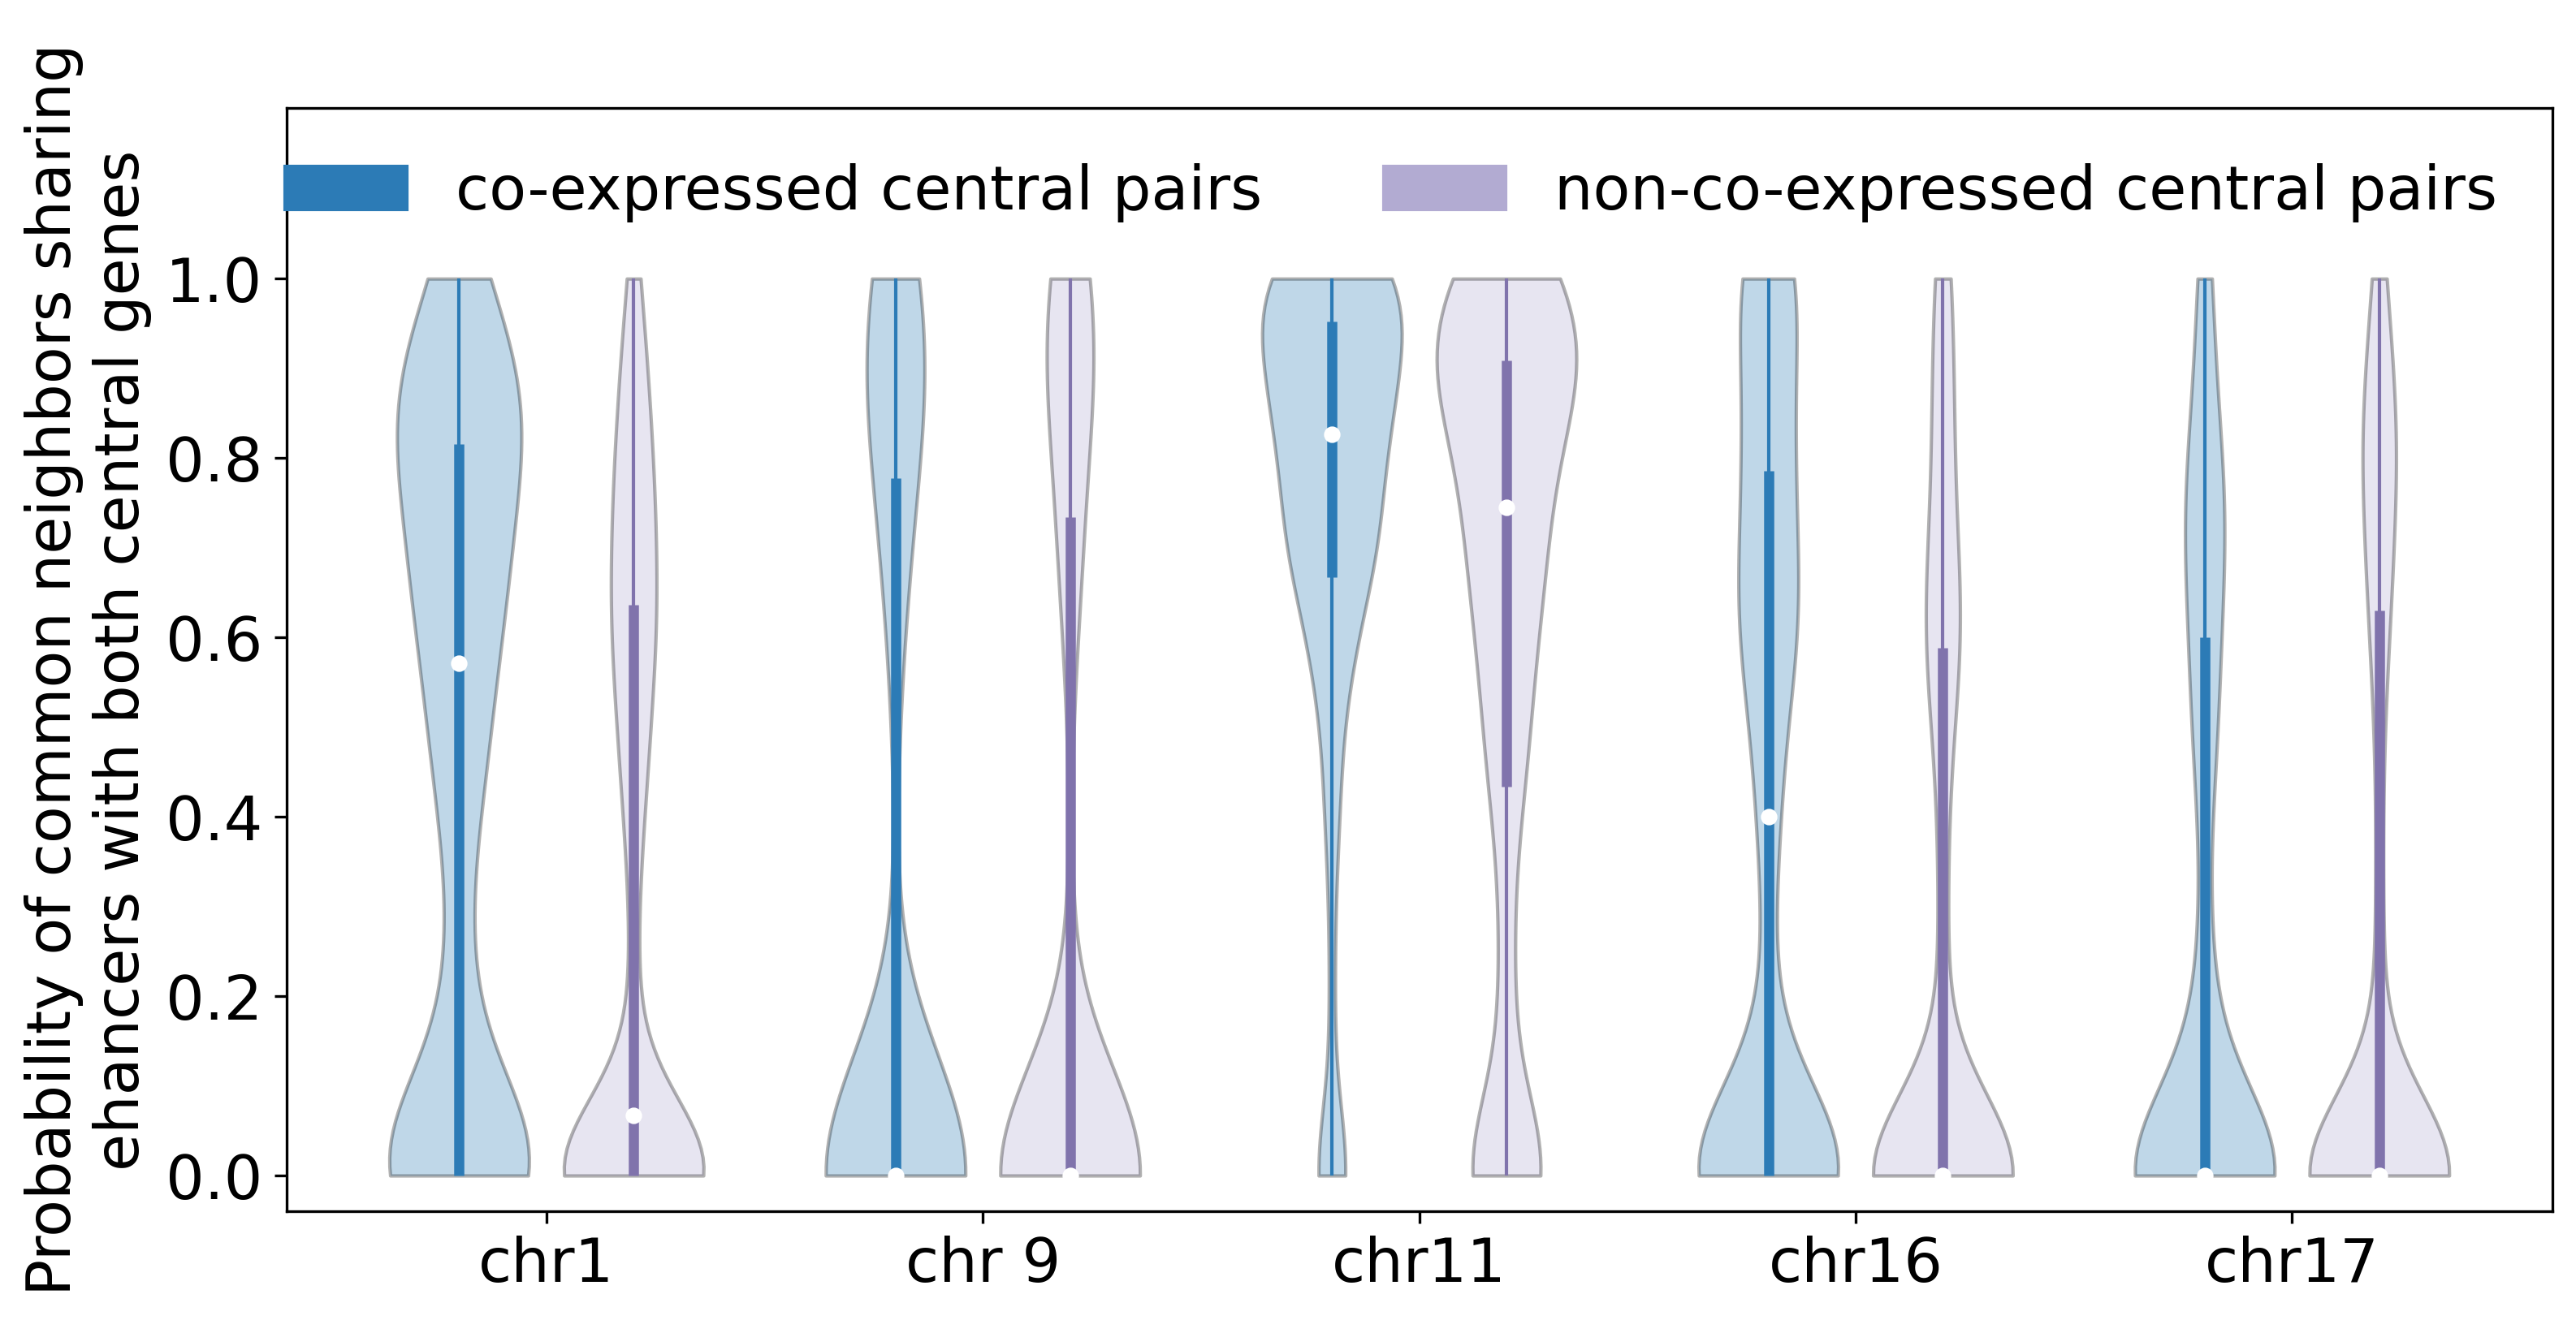

In [50]:
import matplotlib.patches as mpatches
legends = []
def set_violin_color_legend(vp, color, legend):
    for pc in vp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
#     vp['cmaxes'].set_color(color)
#     vp['cmins'].set_color(color)
#     vp['cbars'].set_color(color)
    legends.append((mpatches.Patch(color=color), legend))
    
plt.figure(figsize=(12,6),dpi=300)
num = len(x1_all_supp) # the number of chrom for statistics

pos_1 = [1+i*2.5 for i in range(0,num)]
pos_2 = [p+1 for p in pos_1]
tmp1 = [np.percentile(x,[25,50,75]) for x in x1_all_supp[:num]]
tmp2 = [np.percentile(x,[25,50,75]) for x in x1_all_supp_[:num]]
tmp1_max = [np.max(x) for x in x1_all_supp[:num]]
tmp1_min = [np.min(x) for x in x1_all_supp[:num]]
tmp2_max = [np.max(x) for x in x1_all_supp_[:num]]
tmp2_min = [np.min(x) for x in x1_all_supp_[:num]]


vp_11 = plt.violinplot(x1_all_supp[:num], positions=pos_1[:num], widths=0.8, showextrema=False, showmeans=False, showmedians=False)#, showmedians=True
vp_10 = plt.violinplot(x1_all_supp_[:num], positions=pos_2[:num], widths=0.8, showextrema=False, showmeans=False, showmedians=False)#, showmedians=True

plt.vlines(pos_1, [quantile[0] for quantile in tmp1], [quantile[2] for quantile in tmp1],color='#2C7BB6',linestyle='-',lw=3)
plt.vlines(pos_1, tmp1_min, tmp1_max, color='#2C7BB6', linestyle='-', lw=1)
plt.scatter(pos_1,[quantile[1] for quantile in tmp1],marker='o',color='white',s=15,zorder=3)
plt.vlines(pos_2, [quantile[0] for quantile in tmp2], [quantile[2] for quantile in tmp2],color='#8073ac',linestyle='-',lw=3)
plt.vlines(pos_2, tmp2_min, tmp2_max, color='#8073ac', linestyle='-', lw=1)
plt.scatter(pos_2,[quantile[1] for quantile in tmp2],marker='o',color='white',s=15,zorder=3)

set_violin_color_legend(vp_11, '#2C7BB6', 'co-expressed central pairs')
set_violin_color_legend(vp_10, '#b2abd2', 'non-co-expressed central pairs')    

fsz = 18
# plt.ylim((-0.05, 1.18))
plt.ylim((-0.04, 1.19))
plt.tick_params(labelsize = fsz)
ticks = (np.array(pos_1) + np.array(pos_2)) /2
label=['chr1', 'chr 9', 'chr11', 'chr16', 'chr17']
plt.xticks(ticks=ticks, labels=label,fontsize=fsz)
plt.ylabel('Probability of common neighbors sharing \nehancers with both central genes',fontdict={'fontfamily':'sans-serif', 'fontsize': fsz})
plt.legend(*zip(*legends), loc='upper right', ncol=2, framealpha=0,fontsize=fsz)
# plt.title('Co-expressed gene-neighbor pairs on breast cancer',fontsize=fsz)
plt.show()

(2) compare common neighbors vs. all neighbors (for COPs)

In [51]:
#(1,1)
chrom = '1'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=True, num_nei=10)
share_all_1_r, x1_1_r = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=True, skip=False)
#(1,1)
chrom = '9'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=True, num_nei=10)
share_all_9_r, x1_9_r = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=True, skip=False)
#(1,1)
chrom = '11'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=True, num_nei=10)
share_all_11_r, x1_11_r = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=True, skip=False)
#(1,1)
chrom = '16'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=True, num_nei=10)
share_all_16_r, x1_16_r = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=True, skip=False)
#(1,1)
chrom = '17'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=True, num_nei=10)
share_all_17_r, x1_17_r = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=True, skip=False)

In [52]:
x1_all = [x1_1, x1_9, x1_11, x1_16, x1_17]
x1_all_r = [x1_1_r, x1_9_r, x1_11_r, x1_16_r, x1_17_r]

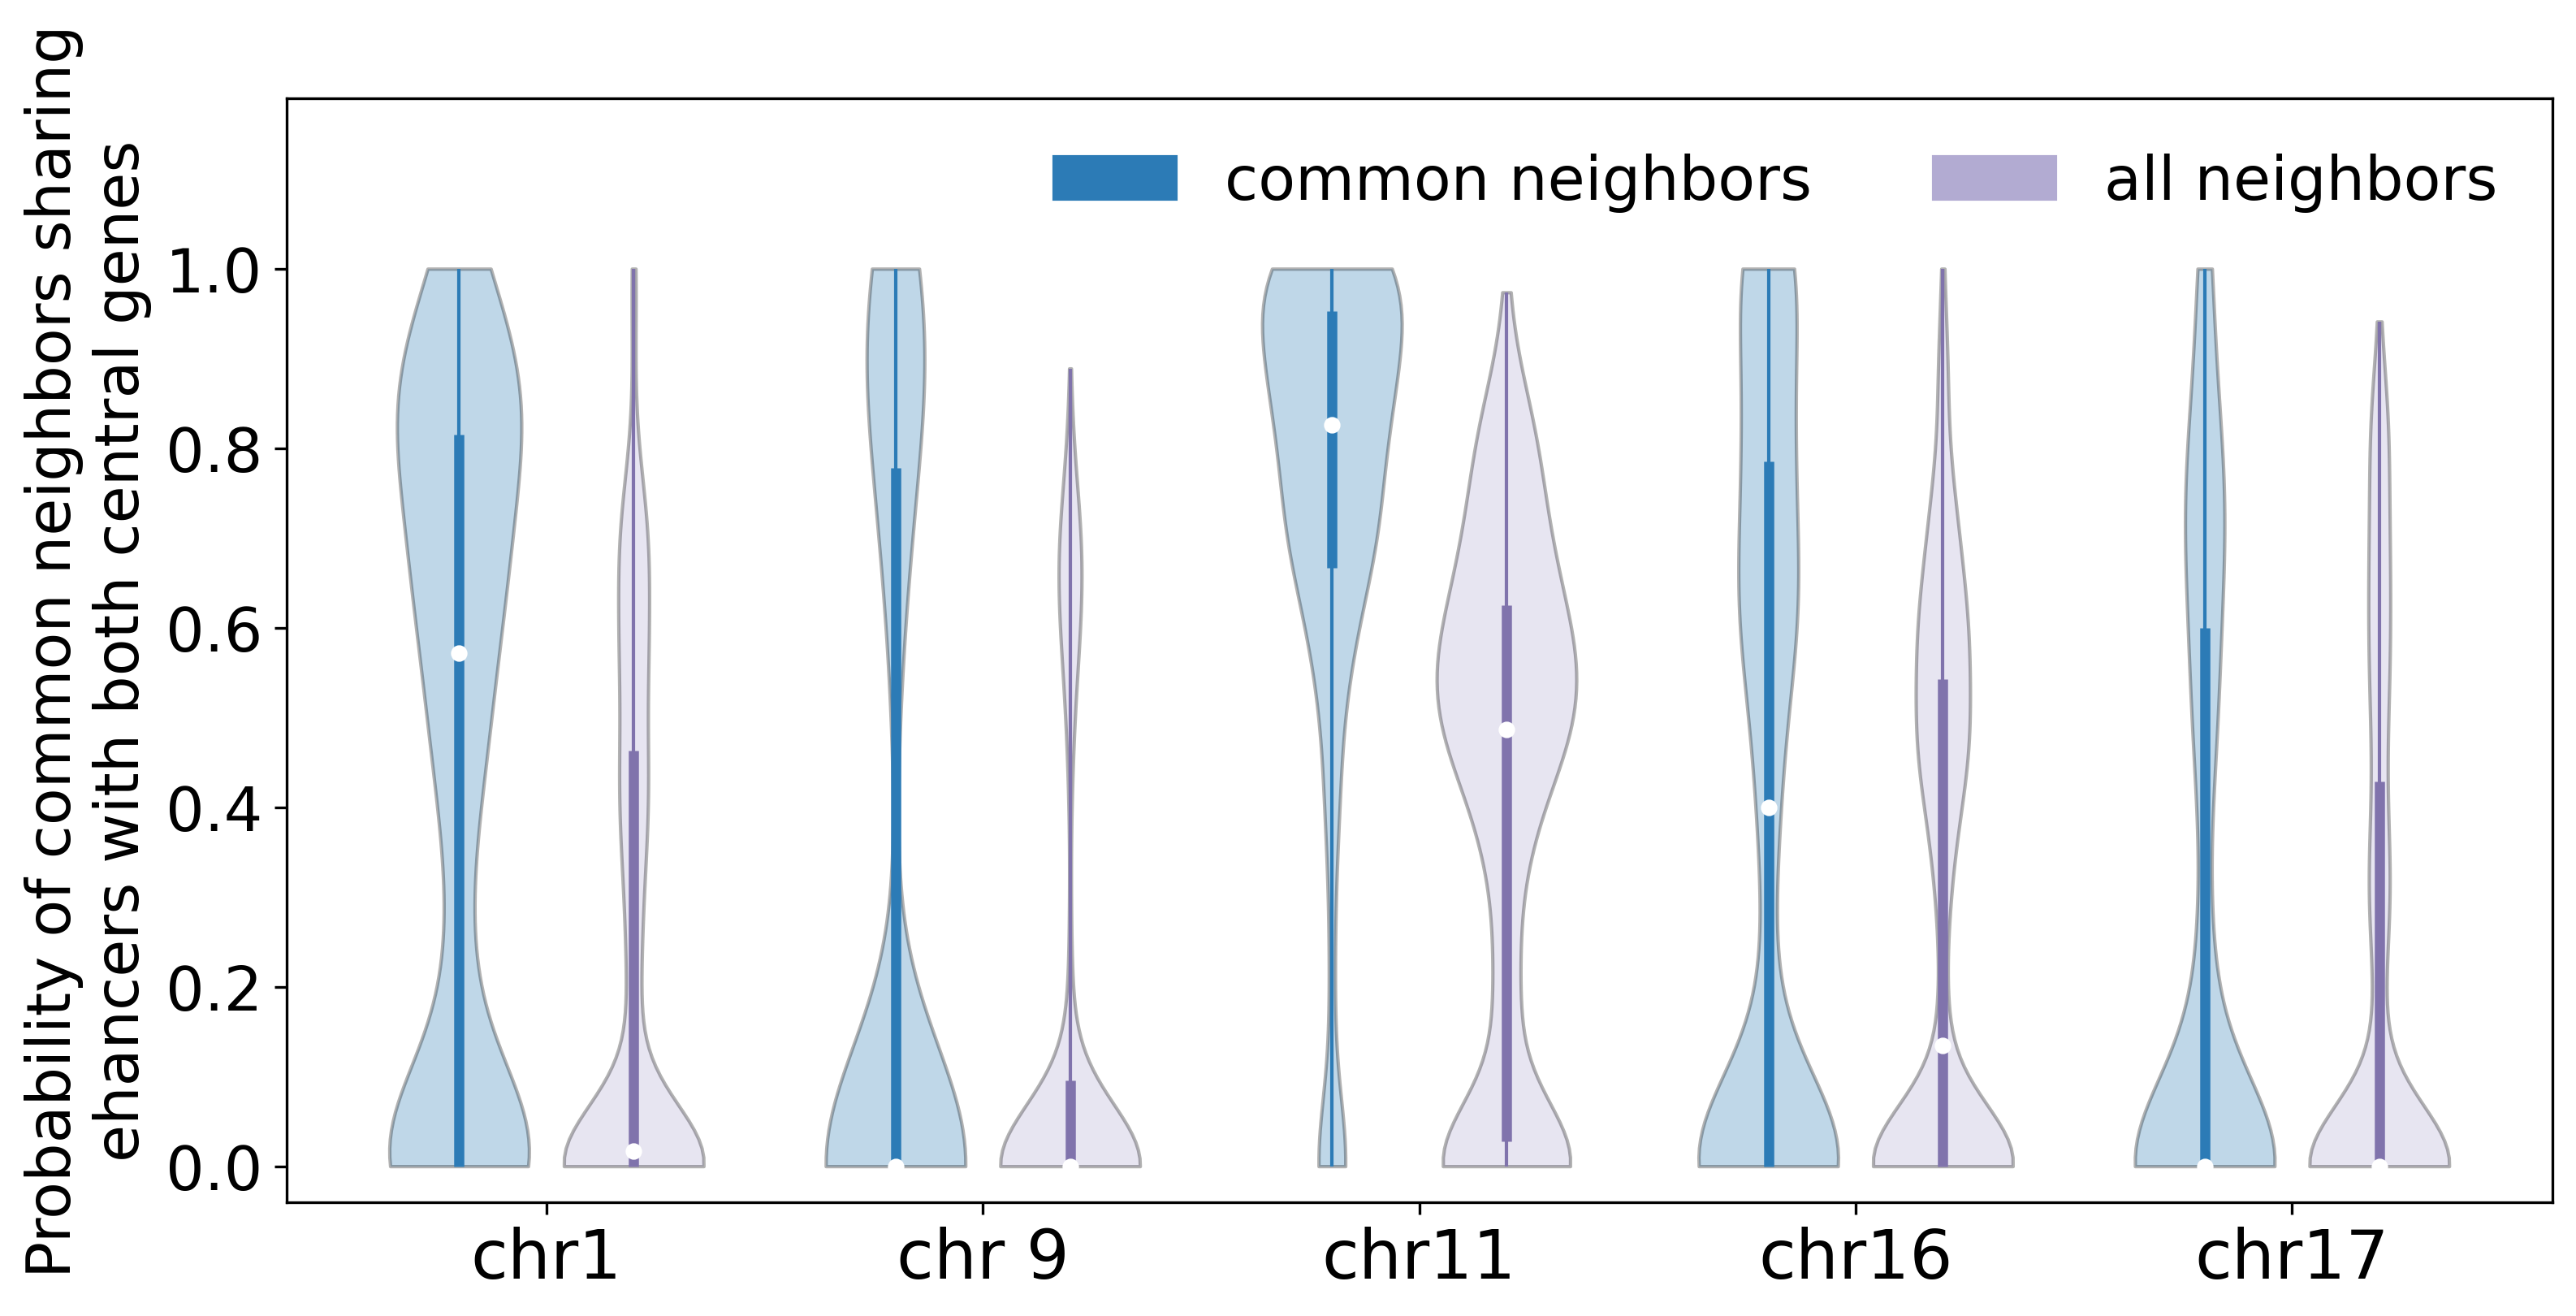

In [53]:
import matplotlib.patches as mpatches
legends = []
def set_violin_color_legend(vp, color, legend):
    for pc in vp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
#     vp['cmaxes'].set_color(color)
#     vp['cmins'].set_color(color)
#     vp['cbars'].set_color(color)
    legends.append((mpatches.Patch(color=color), legend))
    
plt.figure(figsize=(12,6),dpi=300)
# num = 1 
arr1 = x1_all
arr2 = x1_all_r

num = len(x1_all) # the number of chrom for statistics

pos_1 = [1+i*2.5 for i in range(0,num)]
pos_2 = [p+1 for p in pos_1]
tmp1 = [np.percentile(x,[25,50,75]) for x in arr1[:num]]
tmp2 = [np.percentile(x,[25,50,75]) for x in arr2[:num]]
tmp1_max = [np.max(x) for x in arr1[:num]]
tmp1_min = [np.min(x) for x in arr1[:num]]
tmp2_max = [np.max(x) for x in arr2[:num]]
tmp2_min = [np.min(x) for x in arr2[:num]]

vp_11 = plt.violinplot(arr1[:num], positions=pos_1[:num], widths=0.8, showextrema=False, showmeans=False, showmedians=False)#, showmedians=True
vp_10 = plt.violinplot(arr2[:num], positions=pos_2[:num], widths=0.8, showextrema=False, showmeans=False, showmedians=False)#, showmedians=True

plt.vlines(pos_1, [quantile[0] for quantile in tmp1], [quantile[2] for quantile in tmp1],color='#2C7BB6',linestyle='-',lw=3)
plt.vlines(pos_1, tmp1_min, tmp1_max, color='#2C7BB6', linestyle='-', lw=1)
plt.scatter(pos_1,[quantile[1] for quantile in tmp1],marker='o',color='white',s=15,zorder=3)
plt.vlines(pos_2, [quantile[0] for quantile in tmp2], [quantile[2] for quantile in tmp2],color='#8073ac',linestyle='-',lw=3)
plt.vlines(pos_2, tmp2_min, tmp2_max, color='#8073ac', linestyle='-', lw=1)
plt.scatter(pos_2,[quantile[1] for quantile in tmp2],marker='o',color='white',s=15,zorder=3)

set_violin_color_legend(vp_11, '#2C7BB6', 'common neighbors')
set_violin_color_legend(vp_10, '#b2abd2', 'all neighbors')    

fsz = 18
# plt.ylim((-0.05, 1.18))
plt.ylim((-0.04, 1.19))
plt.tick_params(labelsize = fsz)
ticks = (np.array(pos_1) + np.array(pos_2)) /2
label=['chr1', 'chr 9', 'chr11', 'chr16', 'chr17']
plt.xticks(ticks=ticks, labels=label,fontsize=20)
plt.ylabel('Probability of common neighbors sharing\nehancers with both central genes',fontdict={'fontfamily':'sans-serif', 'fontsize': fsz})
plt.legend(*zip(*legends), loc='upper right', ncol=2, framealpha=0,fontsize=fsz)
# plt.title('Co-expressed gene-neighbor pairs on breast cancer',fontsize=fsz)
plt.show()